In [1]:
from esmvalcore.dataset import Dataset

In [2]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='tos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}
model_datasets["ACCESS-ESM1-5"].add_supplementary(short_name='areacello', mip='Ofx')

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='tos',
    dataset='HadISST',
    mip="Omon",
    project='OBS',
    type='reanaly',
    tier=2),
"ERSSTv5":
    Dataset(
    short_name='tos',
    dataset='NOAA-ERSSTv5',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    tier=2),
# "ERA-Interim": 
#     Dataset(
#     short_name='tos',
#     dataset='ERA-Interim',
#     mip="Omon",
#     project='OBS6',
#     type='reanaly',
#     timerange="19790101/20190101",
#     tier=3)
}

In [3]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

In [4]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import monthly_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import axis_statistics
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import mask_landsea
import iris
import numpy as np

import matplotlib.pyplot as plt
import iris.quickplot as qplt
# import cftime

In [7]:
# diag level 2
def prepoc(cube):
    nino34_latext_region = {"start_longitude": 120., "end_longitude": 280., "start_latitude": -5., "end_latitude": 5.}
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino34_latext_region)
    cube = anomalies(cube,period='monthly')

    cube = axis_statistics(cube,axis='y', operator='mean')

    # compute temporal standard deviation
    cube = climate_statistics(cube, operator="std_dev", period="full")
    return cube
    
## sst_std for diag 1
def prepoc_one(cube):
    nino34_latext_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}
    cube = convert_units(cube, units="degC")
    # cube = mask_landsea(cube, mask_out="land")
    cube = extract_region(cube, **nino34_latext_region)
    # remove seasonal cycle
    cube = anomalies(cube, period='monthly')
    #detrend
    cube = area_statistics(cube, operator='mean')
    # compute temporal standard deviation
    cube = climate_statistics(cube, operator="std_dev", period="full")
    return cube

    
def compute(obs, mod):
    return abs((mod-obs)/obs)*100

In [8]:
model_datasets_prep = {name: prepoc_one(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep = {name: prepoc_one(dataset) for name, dataset in obs_datasets.items()}

model_datasets_prep2 = {name: prepoc(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep2 = {name: prepoc(dataset) for name, dataset in obs_datasets.items()}


/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along second dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'cell index along second dimension'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along first dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'cell index along first dimension'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2140: IrisVagueMetadataWarning: Collapsin

Text(0.75, 0.8, '* observation')

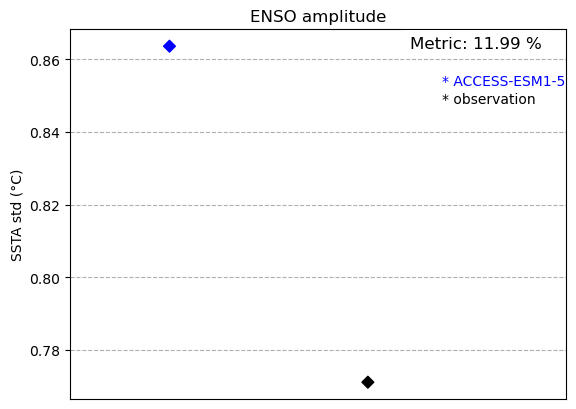

In [9]:
# plot
metric = [model_datasets_prep["ACCESS-ESM1-5"].data.item(), obs_datasets_prep["HadISST"].data.item()]

plt.scatter(range(len(metric)), metric, c=['blue','black'], marker='D')

plt.xlim(-0.5,2)#range(-1,3,1)) #['model','obs']
plt.xticks([])

plt.ylabel('SSTA std (°C)')
plt.grid(linestyle='--', axis='y')
plt.title('ENSO amplitude')

metricval = compute(metric[1],metric[0])

plt.text(0.95, 0.95, f'Metric: {metricval:.2f} %', fontsize=12, ha='right', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.text(0.75,0.85, '* ACCESS-ESM1-5', color='blue',transform=plt.gca().transAxes)
plt.text(0.75,0.8, '* observation', color='black',transform=plt.gca().transAxes)

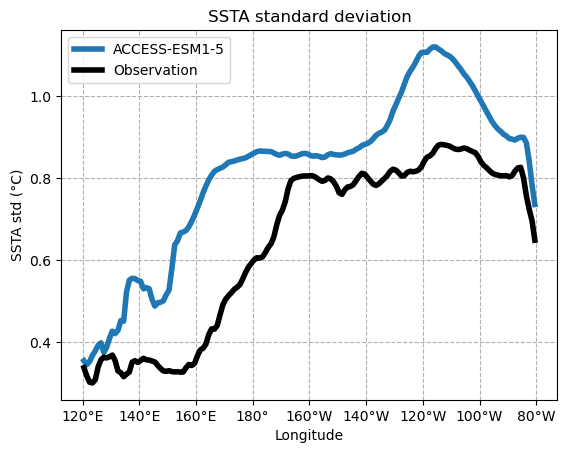

In [12]:
## diag 2 plot
def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'

qplt.plot(model_datasets_prep2["ACCESS-ESM1-5"], label="ACCESS-ESM1-5", linewidth=4)
qplt.plot(obs_datasets_prep2["HadISST"], color='black', label='Observation', linewidth=4)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))

# Adding labels and title
plt.xlabel('Longitude')
plt.ylabel('SSTA std (°C)')
plt.title('SSTA standard deviation')
plt.grid(linestyle='--')
plt.legend()